<a href="https://colab.research.google.com/github/PonVo02/Retail-Campaign-Customer-Segmentation-Python/blob/main/rfm_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Retail Campaign: Customer Segmentation

##**1.Load Data**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_excel("/content/ecommerce retail.xlsx")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
display(df.columns)
display(df.shape)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

(541909, 8)

---

##**2.Quality Check**

### Quality Check

In [13]:
df.info()

n_rows = len(df)
n_invoices = df['InvoiceNo'].nunique()
n_customers_all = df["CustomerID"].nunique(dropna =False)
n_customers_notnull = df["CustomerID"].nunique(dropna=True)

print(f"Number of rows: {n_rows}")
print(f"Number of invoices: {n_invoices}")
print(f"Number of customers (all): {n_customers_all}")
print(f"Number of customers (not null): {n_customers_notnull}")
print ("date min:", df["InvoiceDate"].min())
print ("date max:", df["InvoiceDate"].max())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
Number of rows: 541909
Number of invoices: 25900
Number of customers (all): 4373
Number of customers (not null): 4372
date min: 2010-12-01 08:26:00
date max: 2011-12-09 12:50:00


In [14]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


### QC checks

In [15]:
# CustomerID null
# Cancel Invoices startswith "C"
# Quantity < =0
# UnitPrice <= 0

customer_null = df[df["CustomerID"].isnull()]
cancel_rows = df[df["InvoiceNo"].astype(str).str.startswith("C")]
qty_bad = df[df["Quantity"]<= 0]
price_bad = df[df["UnitPrice"] <= 0]

qc = pd.DataFrame({
    "metric": ["CustomerID null", "Cancelled rows", "Quantity <= 0", " UnitPrice <= 0"],
    "value": [len(customer_null), len(cancel_rows), len(qty_bad), len(price_bad)]
})
qc ["pct"] = qc["value"] / n_rows
qc

,metric,value,pct
0,CustomerID null,135080,0.249267
1,Cancelled rows,9288,0.017139
2,Quantity <= 0,10624,0.019605
3,UnitPrice <= 0,2517,0.004645


### Data Quality Check (RFM)
 - i'm checked missing Customer ID, cancelled invoices (InvoiceNo start with "C"), non-positive Quantity, and non-positive UnitPrice.
- Result:
  + **Rows missing Customer ID** = 135080 ~24.9%
  + **cancelled rows** = 9288 ~1.7%
  + **Quanity <= 0**: 10624 ~2%
  + **UnitPrice < =0** : 2517 ~ 0.46%
- Decision: Drop rows with missing CustomerID and remove cancelled/non-positive transaction to avoid biased RFM scoré and misleading segmentation


--------------------------------

##**3.Clean & Prepare transactions for RFM**

###Why clean Data:
 RFM segmentation must reflect real purchase behavior. Missing CustomerID, cancellations, and non-positive Quantity/UnitPrice can distort Monetary and Frequency, leading to wrong customer segments and misleading marketing decisions.

 **Cleaning rules applied:**

 - Remove row with missing CustomerID (cannot assign purchases to a customer).
 - Exclude cancelled invoices (InvoiceNo starts with"C")
 - keep only valid sales transactions where Quanity > 0 and UnitPrice > 0.
 - Create Sales = Quantity * UnitPrice to represent trasaction value (Monetary)

In [16]:
df2= df.copy()
df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"])


# drop CustomerID null
# remove cancelled invoices (InvoiceNO start with"C")
# keep Quanity > 0, UnitPrice > 0
#remove __isNull (Use ~ to reverse the condition.)


df2 = df2 [
    (~df2["CustomerID"].isnull()) & #  ~ to reverse the condition.
    (~df2["InvoiceNo"].astype(str).str.startswith("C", na=False)) &
    (df2["Quantity"]>0) &
    (df2["UnitPrice"]>0)
]
df2["Sales"] = df2["Quantity"]*df2["UnitPrice"]
print(f"Data before cleaning: {df.shape}")
print(f"Data after cleaning: {df2.shape}")
print(f"Number of rows dropped: {len(df)-len(df2)}")

#sanity check
assert df2["CustomerID"].notna().all()
assert (~df2["InvoiceNo"].astype(str).str.startswith("C", na=False).all())
assert (df2["Quantity"]>0).all()
assert (df2["UnitPrice"]>0).all()

Data before cleaning: (541909, 8)
Data after cleaning: (397884, 9)
Number of rows dropped: 144025


**Result**

- Rows before cleaning: 541,909
- Rows after cleaning: 397,884
- Rows dropped: 144,025

-> This cleaned dataset will be used to compute RFM metrics using snapshot date 2011-12-31.

---------------------------------------------

##**4.Built RFM**
**Purpose:** Transform transaction-level data into customer-level metrics for segmentation. Each customer receives:
- Recency: days since the most recent purchase (lower is better)
- Frequency: number of unique invoices/purchases (higher is better)
- Monetary: total spending (higher is better)

In [17]:
snapshot = pd.Timestamp("2011-12-31")

rfm = (
    df2.groupby("CustomerID")
    .agg(
        Recency = ("InvoiceDate", lambda x: (snapshot - x.max()).days),
        Frequency = ("InvoiceNo", "nunique"),
        Monetary = ("Sales", "sum")
    )
)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,346,1,77183.60
12347.0,23,7,4310.00
12348.0,96,4,1797.24
12349.0,39,1,1757.55
12350.0,331,1,334.40


In [18]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,113.059474,4.272015,2054.266460
std,100.012264,7.697998,8989.230441
min,21.000000,1.000000,3.750000
25%,38.000000,1.000000,307.415000
50%,71.000000,2.000000,674.485000
75%,162.750000,5.000000,1661.740000
max,394.000000,209.000000,280206.020000


###RFM summary (after cleaning):
- Customers: 4,338
- Recency: min 21, median 71, max 394
- Frequency: median 41
- Monetary: highly right-skewed (mean 2054 vs median 674, max 280,206) indicating a small group of high-value customers.

=>**Implication for marketing:** The customer base likely contains a small VIP segment driving a disproportionate share of revenue, making segmentation crucial for efficient holiday campaigns.

###4.1 Quintile mindset SetUp (RFM)

In [19]:
#Recency: càng nhỏ càng tốt -> score đảo chiều
#Frequency, Monetary: càng lớn càng tốt

rfm = rfm.copy()

rfm['R_Score'] = pd.qcut(rfm['Recency'],5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'),5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'],5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,346,1,77183.60,1,1,5,115
12347.0,23,7,4310.00,5,5,5,555
12348.0,96,4,1797.24,2,4,4,244
12349.0,39,1,1757.55,4,1,4,414
12350.0,331,1,334.40,1,1,2,112


---

##**5.Segment + Visualize + Insights**

###Segment mapping

In [20]:
seg = pd.read_excel('/content/ecommerce retail.xlsx', sheet_name='Segmentation')

seg_map ={}
for _, row in seg.iterrows():
  scores =[s.strip() for s in str(row["RFM Score"]).split(",")]
  seg_map[row["Segment"]] = set(scores)

def assign_segment(score: str) -> str:
  for name, sset in seg_map.items():
    if score in sset:
      return name
  return "Others"

rfm["Segment"] = rfm["RFM_Score"].apply(assign_segment)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,346,1,77183.60,1,1,5,115,Cannot Lose Them
12347.0,23,7,4310.00,5,5,5,555,Champions
12348.0,96,4,1797.24,2,4,4,244,At Risk
12349.0,39,1,1757.55,4,1,4,414,Promising
12350.0,331,1,334.40,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...
18280.0,298,1,180.60,1,2,1,121,Lost customers
18281.0,201,1,80.82,1,2,1,121,Lost customers
18282.0,28,2,178.05,5,3,1,531,Potential Loyalist


**Create 3 metric by segment**
- Revenue Contribution
- Segment Size
- Freshness

In [21]:
rfm = rfm.reset_index()

In [22]:
# 3 metrics summary table
segment_metrics = (
    rfm.groupby("Segment")
               .agg(
                   customers=("CustomerID", "nunique"),
                   revenue=("Monetary", "sum"),
                   median_recency=("Recency", "median")
               )
               .sort_values("revenue", ascending=False)
)

segment_metrics["customer_pct"] = segment_metrics["customers"] / segment_metrics["customers"].sum()
segment_metrics["revenue_pct"] = segment_metrics["revenue"] / segment_metrics["revenue"].sum()

segment_metrics

,customers,revenue,median_recency,customer_pct,revenue_pct
Segment,,,,,
Champions,835,5604376.680,29.0,0.192485,0.628899
Loyal,428,1021224.390,57.0,0.098663,0.114597
At Risk,422,751808.221,140.5,0.097280,0.084365
Need Attention,280,462835.741,52.0,0.064546,0.051937
Hibernating customers,696,285673.342,149.0,0.160443,0.032057
Potential Loyalist,414,225740.110,43.0,0.095436,0.025332
Cannot Lose Them,91,203671.300,260.0,0.020977,0.022855
Promising,136,121031.350,37.5,0.031351,0.013582
Lost customers,486,97405.610,291.0,0.112033,0.010930


###Visualize

**Create Color map**

In [23]:
segments = segment_metrics.index.tolist()
cmap = plt.cm.get_cmap("tab20", len(segments))
SEGMENT_COLORS = {seg: cmap(i) for i, seg in enumerate(segments)}

/tmp/ipython-input-535/2178087376.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(segments))


**Customer by segment**

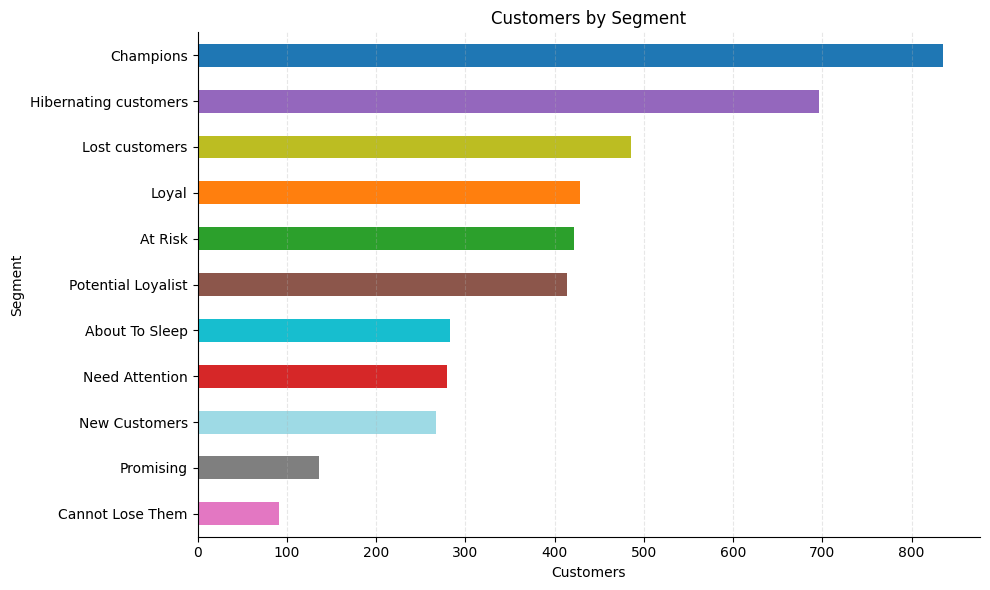

In [24]:
s = segment_metrics["customers"].sort_values()
colors = [SEGMENT_COLORS[seg] for seg in s.index]

plt.figure(figsize=(10, 6))
ax = s.plot(kind="barh", color=colors)
ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Customers by Segment")
plt.xlabel("Customers")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

**Insight (Customers by Segment):**
- The customer base is concentrated in **Champions** (largest segment) and a large inactive pool (**Hibernating customers** and **Lost customers**).
- This suggests Superstore has strong high-value engagement, but also a significant number of customers who have become inactive and may require reactivation strategies.
- For the holiday campaign, broad reach should focus on large segments (Champions / Hibernating / Lost), but incentives should be differentiated to avoid overspending on low-response groups.
---

**Revenue by segment**

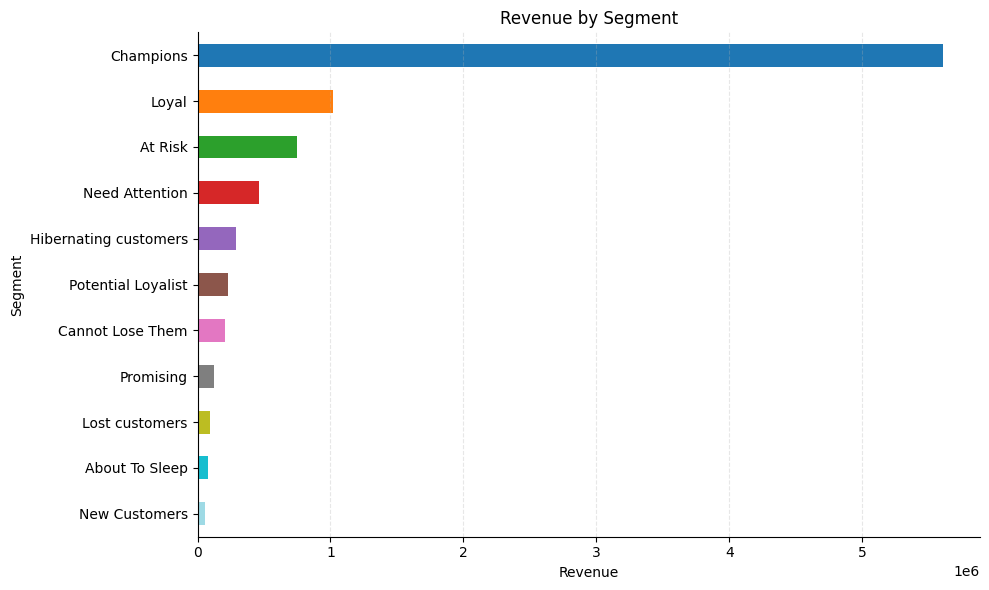

In [25]:
s = segment_metrics["revenue"].sort_values()
colors = [SEGMENT_COLORS[seg] for seg in s.index]

plt.figure(figsize=(10, 6))
ax = s.plot(kind="barh", color=colors)
ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Revenue by Segment")
plt.xlabel("Revenue")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

**Insight (Revenue by Segment):**
- **Champions dominate total revenue**, indicating a small group of highly valuable customers drives a disproportionate share of sales.
- **Loyal** and **At Risk** contribute meaningful revenue but are far behind Champions; these are critical “second-tier” groups where retention/win-back can protect revenue efficiently.
- Marketing should prioritize premium rewards for Champions, while designing targeted win-back offers for At Risk to prevent revenue leakage during the holiday period.
---

**Median recency by segment**

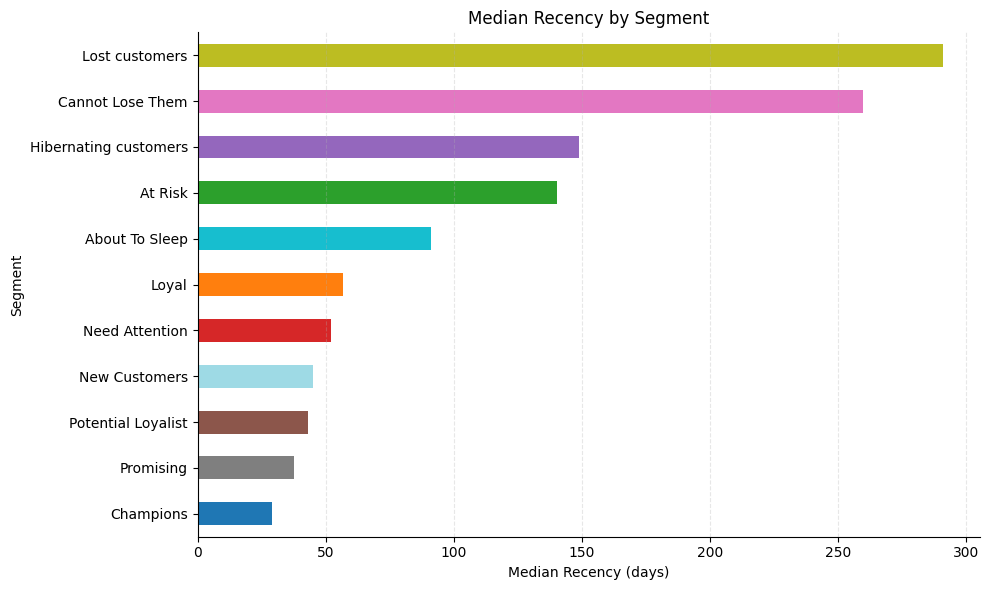

In [26]:
s = segment_metrics["median_recency"].sort_values()
colors = [SEGMENT_COLORS[seg] for seg in s.index]

plt.figure(figsize=(10, 6))
ax = s.plot(kind="barh", color=colors)
ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Median Recency by Segment")
plt.xlabel("Median Recency (days)")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

**Insight (Median Recency by Segment):**
- Recency clearly separates active vs inactive customers: **Champions have the lowest median recency** (most recently active), while **Lost customers** and **Cannot Lose Them** show very high recency (cold customers).
- High recency segments represent churn risk; these customers are less likely to respond without stronger incentives or personalized messaging.
- Recommended focus: keep Champions warm (light rewards + upsell), and run win-back campaigns for At Risk / Cannot Lose Them with personalized offers and reminders to recover high-value customers.
----

### Insight

## Key Findings (from segment_metrics)

- **Champions dominate revenue:** Champions account for **~19.2% customers** but generate **~62.9% of total revenue** (median recency **26 days**) -> this is the core growth & profit engine.
- **Big inactive base but low value:** Hibernating + Lost represent **~27.2% customers** (Hibernating **16.0%**, Lost **11.2%**) but contribute only **~4.3% revenue** (median recency **143–290 days**) -> reactivation should be low-cost.
- **Revenue at risk:** **At Risk** makes up **~9.7% customers** and **~8.4% revenue** with median recency **135 days** ->> immediate win-back can protect revenue efficiently.
- **Loyal is the “second pillar”:** Loyal contributes **~11.5% revenue** with median recency **59 days** -> focus on retention + upsell to expand share beyond Champions.

## Holiday Campaign Priority (Top 3 Targets)

**Priority 1 — Champions (Protect & Monetize)**
- Highest impact segment (62.9% revenue, low recency 26 days).
- Retain + increase basket size (AOV) without heavy discounting.

**Priority 2 — Loyal (Grow into Champions)**
- Strong revenue base (11.5% revenue) and still relatively active (59 days).
- Drive repeat purchase and upgrade them into Champions via bundles/loyalty perks.

**Priority 3 — At Risk (Win-back to prevent revenue leakage)**
- Meaningful revenue at risk (8.4% revenue) but cold (135 days).
- Bring them back with targeted win-back offers; this is often cheaper than acquiring new customers.

## Segment Recommendations (Action Plan)

### Champions (19.2% customers / 62.9% revenue / Recency 26)
- **Strategy:** VIP appreciation + upsell/cross-sell
- **Tactics:** early access, premium bundles, points multiplier, referral reward
- **Avoid:** deep discounts (protect margin)

### Loyal (9.9% customers / 11.5% revenue / Recency 59)
- **Strategy:** retention + convert to Champions
- **Tactics:** “buy again in 7–14 days” incentive, bundles, free shipping threshold

### At Risk (9.7% customers / 8.4% revenue / Recency 135)
- **Strategy:** win-back (high ROI)
- **Tactics:** limited-time comeback offer + personalized recommendations; higher incentive than normal
- **Note:** prioritize high-value subset first

### Need Attention (6.5% customers / 5.2% revenue / Recency 49)
- **Strategy:** nurture to prevent churn
- **Tactics:** curated deals, seasonal gift guides, light incentive

### Potential Loyalist (9.5% customers / 2.5% revenue / Recency 44)
- **Strategy:** increase frequency (2nd/3rd purchase)
- **Tactics:** post-purchase email series + “next order” coupon

### New Customers (6.2% customers / 0.7% revenue / Recency 45)
- **Strategy:** onboarding
- **Tactics:** welcome flow + low-friction second purchase offer

### Cannot Lose Them (2.1% customers / 2.3% revenue / Recency 239)
- **Strategy:** rescue high-value but very cold customers
- **Tactics:** personalized outreach, special comeback credit, customer service follow-up

### Hibernating + Lost (27.2% customers / 4.3% revenue / Recency 143–290)
- **Strategy:** low-cost reactivation only
- **Tactics:** broad holiday deals email; stop paid spend if no response after 2–3 touches

## Which metric matters most for Superstore (R vs F vs M)?

For a holiday campaign, the priority should be:

1) **Recency (R)** — determines *reachability and response likelihood*. Cold segments (Lost/Cannot Lose Them) have very high recency, so broad promotions there will be inefficient.
2) **Monetary (M)** — guides *budget allocation*. Champions generate ~62.9% revenue, so VIP rewards should focus here to maximize impact.
3) **Frequency (F)** — supports long-term loyalty building, but for short seasonal timing it is less decisive than R and M.

**Conclusion:** For this project context, prioritize **R > M > F**.
-----
